In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import ER_multiclass as ER

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_excel('../BreastTissue_data.xls')

In [4]:
df.head()

,Case #,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
0,1,car,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
1,2,car,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
2,3,car,551.879287,0.232478,0.063530,264.804935,11888.391827,44.894903,77.793297,253.785300,656.769449
3,4,car,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
4,5,car,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503


In [5]:
df = np.array(df)

In [6]:
X = df[:,2:].astype(float) # not take the 1rst and 2nd columns
X.shape

(106, 9)

In [7]:
y = df[:,1]

In [8]:
np.unique(y,return_counts=True)

(array(['adi', 'car', 'con', 'fad', 'gla', 'mas'], dtype=object),
 array([22, 21, 14, 15, 16, 18]))

In [9]:
# merge 'fad' (Fibro-adenoma), 'glas' (Glandular) and 'mas' (Mastopathy)
l,n = X.shape
ynew = np.ones(l)

t2 = y =='adi'
ynew[t2] = 2

t3 = y =='car'
ynew[t3] = 3

t4 = y =='con'
ynew[t4] = 4

In [10]:
np.unique(ynew,return_counts=True)

(array([1., 2., 3., 4.]), array([49, 22, 21, 14]))

In [11]:
y = ynew

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')

In [13]:
y = onehot_encoder.fit_transform(y.reshape(-1,1))
y = np.argmax(y,axis=1)
y.shape

(106,)

## Shuffle data

In [14]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [15]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [16]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.002)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(multi_class='multinomial',solver='saga')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [17]:
def compare_inference(X,y,train_size):
    npred = 10
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [18]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.83181818 0.87727273 0.87272727 0.89545455]
0.6 [0.81818182 0.87727273 0.86818182 0.88636364]
0.4 [0.77272727 0.85454545 0.82272727 0.86818182]
0.2 [0.72727273 0.75454545 0.69090909 0.83636364]


In [19]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.831818,0.877273,0.872727,0.895455
1,0.6,0.818182,0.877273,0.868182,0.886364
2,0.4,0.772727,0.854545,0.822727,0.868182
3,0.2,0.727273,0.754545,0.690909,0.836364


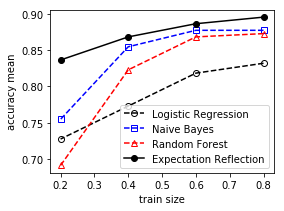

In [20]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

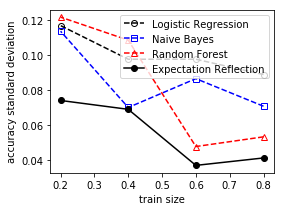

In [21]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()

In [22]:
np.savetxt('breasttissue_acc.txt',acc,fmt='%f')
np.savetxt('breasttissue_acc_std.txt',acc_std,fmt='%f')